# CUDA Installation

In [1]:
!apt update -qq;
!wget https://developer.nvidia.com/compute/cuda/8.0/Prod2/local_installers/cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64-deb;
!dpkg -i cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64-deb;
!apt-key add /var/cuda-repo-8-0-local-ga2/7fa2af80.pub;
!apt-get update -qq;
!apt-get install cuda gcc-5 g++-5 -y -qq;
!ln -s /usr/bin/gcc-5 /usr/local/cuda/bin/gcc;
!ln -s /usr/bin/g++-5 /usr/local/cuda/bin/g++;
!apt install cuda-8.0;


78 packages can be upgraded. Run 'apt list --upgradable' to see them.
--2019-11-14 17:19:43--  https://developer.nvidia.com/compute/cuda/8.0/Prod2/local_installers/cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 192.229.162.216
Connecting to developer.nvidia.com (developer.nvidia.com)|192.229.162.216|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/8.0/secure/Prod2/local_installers/cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64.deb?Gl0RzOso3B5B_04DfpgBhuC3ng0ZUTBsHuJOMoD5mBSU4BjZNeIxte0Ja2iFHTt1MitFbtqm84Qs6GEAcLdwRykaqixFVHyIDJFo7LEvqYAX_l--dlQX8PRJuqqJ1eeBItMtFWPdCUvob9ewQXxp3d4JWqIrs3jHAPib99OTiAByIH7xA7qPtkAYIL8UAYqGxj4UVv1bISSm5SWnCbLss239IA [following]
--2019-11-14 17:19:44--  https://developer.download.nvidia.com/compute/cuda/8.0/secure/Prod2/local_installers/cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64.deb?Gl0RzOso3B5B_04DfpgBhu

In [2]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2016 NVIDIA Corporation
Built on Tue_Jan_10_13:22:03_CST_2017
Cuda compilation tools, release 8.0, V8.0.61


In [3]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-w_gt0y3g
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-w_gt0y3g
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp36-none-any.whl size=4307 sha256=aa0809a7521c5d9d86715e185732ac96137b85380d529aa2dc3016ec7d08e545
  Stored in directory: /tmp/pip-ephem-wheel-cache-jspx7k02/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin


In [4]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random, math, os, time

In [0]:
SEED = 1234
random.seed(SEED)

In [0]:
train_sampling_params = {
    'dim_in': 11,
    'output_length': 5,
    'min_before': 20,
    'max_before': 25,
    'min_after': 20,
    'max_after': 25,
    'file_path': './SSIM/data/simplified_PM25.csv'
}

In [0]:
test_sampling_params = {
  'dim_in': 11,
  'output_length': 5,
  'min_before': 25,
  'max_before': 25,
  'min_after': 25,
  'max_after': 25,
  'file_path': './SSIM/data/simplified_PM25.csv'
}

In [0]:
filepath = 'https://raw.githubusercontent.com/vishal-pandey/SSIM/master/SSIM/data/simplified_PM25.csv'
df = pd.read_csv(filepath, dayfirst=True)

In [220]:
df.head()

,date,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,winddirect_0,winddirect_1,winddirect_2,winddirect_3
0,2/01/2010 0:00,129,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
1,2/01/2010 1:00,148,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2,2/01/2010 2:00,159,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
3,2/01/2010 3:00,181,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
4,2/01/2010 4:00,138,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


In [0]:
len(df[:5000])
df = df[:5000]

In [222]:
print(df.iloc[0, 0])
print(df.iloc[4000, 0])
print(df.iloc[4001, 0])
print(df.iloc[4999, 0])


df.set_index('date', inplace=True)

2/01/2010 0:00
17/06/2010 16:00
17/06/2010 17:00
29/07/2010 7:00


In [223]:
df.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,winddirect_0,winddirect_1,winddirect_2,winddirect_3
date,,,,,,,,,,,
2/01/2010 0:00,129,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2/01/2010 1:00,148,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2/01/2010 2:00,159,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2/01/2010 3:00,181,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2/01/2010 4:00,138,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


In [0]:
pm25 = df['pm2.5'].values.copy().reshape(-1, 1)

In [225]:
# Standaraization, Use Standard Scalar
scaler_x = StandardScaler()
scaler_x.fit(df[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
df[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']] = scaler_x.transform(df[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']])

In [0]:
scaler_y = StandardScaler()
scaler_y.fit(pm25)
y_all = scaler_y.transform(pm25)

In [0]:
df_train = df.loc['2/01/2010 0:00': '17/06/2010 16:00'].copy()
df_test = df.loc['17/06/2010 17:00': '29/07/2010 7:00'].copy()
# df['date']

# df_train = df.loc['2/01/2010 0:00':'31/12/2013 23:00'].copy()
# df_test = df.loc['1/01/2014 0:00':'31/12/2014 23:00'].copy()

In [0]:
y = y_all

In [230]:
print(df_train)
print(df_test)
print(y)
print(scaler_x)
print(scaler_y) 

                     pm2.5      DEWP  ...  winddirect_2  winddirect_3
date                                  ...                            
2/01/2010 0:00    0.417185 -1.120914  ...             1             0
2/01/2010 1:00    0.661813 -1.052113  ...             1             0
2/01/2010 2:00    0.803439 -0.776907  ...             1             0
2/01/2010 3:00    1.086692 -0.501701  ...             1             0
2/01/2010 4:00    0.533062 -0.501701  ...             1             0
...                    ...       ...  ...           ...           ...
17/06/2010 12:00 -0.999080  1.149536  ...             1             0
17/06/2010 13:00 -0.793078  1.149536  ...             0             1
17/06/2010 14:00 -0.973329  1.149536  ...             0             0
17/06/2010 15:00 -1.037705  1.149536  ...             0             0
17/06/2010 16:00 -0.908954  1.218337  ...             0             1

[4001 rows x 11 columns]
                     pm2.5      DEWP  ...  winddirect_2  winddir

In [0]:
def train_val_test_generate(dataframe, model_params):
    '''
    :param dataframe: processed dataframe
    :param model_params: for input dim
    :return: train_x, train_y, test_x, test_y with the same length (by padding zero)
    '''

    train_val_test_x, train_val_test_y, len_x_samples, len_before_x_samples = pad_all_cases(dataframe,
                                                                                            dataframe['pm2.5'].values,
                                                                                            model_params,
                                                                                            model_params['min_before'],
                                                                                            model_params['max_before'],
                                                                                            model_params['min_after'],
                                                                                            model_params['max_after'],
                                                                                            model_params[
                                                                                                'output_length'])

    train_val_test_y = np.expand_dims(train_val_test_y, axis=2)

    return train_val_test_x, train_val_test_y, len_x_samples, len_before_x_samples

In [0]:

def generate_samples(x, y, model_params, seq_len_before=7, seq_len_after=7, output_seq_len=9):
    """
    Generate samples, input past and future, target middle
    :param x: input dataframe
    :param y: target variable to impute
    :param seq_len_before:
    :param seq_len_after:
    :param output_seq_len:
    :return: (inputsequence, targetsequence)
    """
    total_samples = x.shape[0]
    total_len = seq_len_before + seq_len_after + output_seq_len

    input_batch_idxs = [list(range(i, i + seq_len_before)) + list(
        range(i + seq_len_before + output_seq_len, i + seq_len_before + output_seq_len + seq_len_after)) for i in
                        range((total_samples - total_len + 1))]

    input_seq = np.take(x, input_batch_idxs, axis=0)

    z = np.zeros((output_seq_len, model_params['dim_in']))

    input_seq = np.array([np.concatenate((i[:seq_len_before], z, i[seq_len_before:])) for i in input_seq])

    output_batch_idxs = [list(range(i + seq_len_before, i + seq_len_before + output_seq_len)) for i in
                         range((total_samples - total_len + 1))]

    output_seq = np.take(y, output_batch_idxs, axis=0)

    return input_seq, output_seq


def pad_all_cases(x, y, model_params, min_len_before=7, max_len_before=9, min_len_after=7, max_len_after=9,
                  targetlength=9):
    """
    variable length inputs, fix length outputs
    :param x: input dataframe
    :param y: target variable to impute
    :param min_len_before:
    :param max_len_before:
    :param min_len_after:
    :param max_len_after:
    :param targetlength:
    :return: inputsequence with same length, outputsequence with same length
    """
    total_x = []
    total_y = []
    total_len_x = []
    totle_len_before_x = []

    for l_before in range(min_len_before, max_len_before + 1):
        for l_after in range(min_len_after, max_len_after + 1):
            case_x, case_y = generate_samples(x.values, y, model_params, l_before, l_after, targetlength)
            # npad is a tuple of (n_before, n_after) for each dimension

            len_x = np.full(case_x.shape[0], case_x.shape[1])
            len_before_sequence_x = np.full(case_x.shape[0], l_before)

            npad = ((0, 0), (0, max_len_before - l_before + max_len_after - l_after), (0, 0))

            same_length_x = np.pad(case_x, pad_width=npad, mode='constant', constant_values=0)

            total_x.append(same_length_x)
            total_y.append(case_y)
            total_len_x.append(len_x)
            totle_len_before_x.append(len_before_sequence_x)

    ## total x,y
    concatenated_x = np.concatenate(total_x, axis=0)
    concatenated_y = np.concatenate(total_y, axis=0)
    len_all_case = np.concatenate(total_len_x).ravel()
    len_before_all_case = np.concatenate(totle_len_before_x).ravel()

    return concatenated_x, concatenated_y, len_all_case, len_before_all_case

In [0]:
# x_samples, y_samples, x_len, x_before_len = train_val_test_generate(df_train, train_sampling_params)
# def train_val_test_generate(dataframe, model_params):

dataframe = df_train
dataframe1 = df_test
model_params = train_sampling_params

# train_val_test_x, train_val_test_y, len_x_samples, len_before_x_samples = pad_all_cases(dataframe,
#                                                                                             dataframe['pm2.5'].values,
#                                                                                             model_params,
#                                                                                             model_params['min_before'],
#                                                                                             model_params['max_before'],
#                                                                                             model_params['min_after'],
#                                                                                             model_params['max_after'],
#                                                                                             model_params[
#                                                                                                 'output_length'])




# def pad_all_cases(x, y, model_params, min_len_before=7, max_len_before=9, min_len_after=7, max_len_after=9,
#                   targetlength=9):

In [0]:
x_test, y_test, x_test_len, x_test_before_len = train_test_split_SSIM(x_samples, y_samples, x_len, x_before_len,
                                                                          test_sampling_params, SEED)

In [0]:
x = dataframe
x1 = dataframe1
y = dataframe['pm2.5'].values
y1 = dataframe1['pm2.5'].values
# model_params = model_params
min_len_before = model_params['min_before']
max_len_before = model_params['max_before']
min_len_after = model_params['min_after'] 
max_len_after = model_params['max_after']
targetlength = model_params['output_length']

In [0]:
total_x = []
total_y = []
total_len_x = []
total_len_before_x = []

In [0]:
def generate_samples(x, y, model_params, seq_len_before=7, seq_len_after=7, output_seq_len=9):
    """
    Generate samples, input past and future, target middle
    :param x: input dataframe
    :param y: target variable to impute
    :param seq_len_before:
    :param seq_len_after:
    :param output_seq_len:
    :return: (inputsequence, targetsequence)
    """
    total_samples = x.shape[0]
    total_len = seq_len_before + seq_len_after + output_seq_len

    input_batch_idxs = [list(range(i, i + seq_len_before)) + list(
        range(i + seq_len_before + output_seq_len, i + seq_len_before + output_seq_len + seq_len_after)) for i in
                        range((total_samples - total_len + 1))]

    input_seq = np.take(x, input_batch_idxs, axis=0)

    z = np.zeros((output_seq_len, model_params['dim_in']))

    input_seq = np.array([np.concatenate((i[:seq_len_before], z, i[seq_len_before:])) for i in input_seq])

    output_batch_idxs = [list(range(i + seq_len_before, i + seq_len_before + output_seq_len)) for i in
                         range((total_samples - total_len + 1))]

    output_seq = np.take(y, output_batch_idxs, axis=0)

    return input_seq, output_seq

In [0]:
for l_before in range(min_len_before, max_len_before+1):
  for l_after in range(min_len_after, max_len_after+1):
    case_x, case_y = generate_samples(x.values, y, model_params, l_before, l_after, targetlength)
    
    len_x = np.full(case_x.shape[0], case_x.shape[1])
    len_before_sequence_x = np.full(case_x.shape[0], l_before)

    npad = ((0, 0), (0, max_len_before - l_before + max_len_after - l_after), (0, 0))

    same_length_x = np.pad(case_x, pad_width=npad, mode='constant', constant_values=0)

    total_x.append(same_length_x)

    total_y.append(case_y)

    total_len_x.append(len_x)

    total_len_before_x.append(len_before_sequence_x)

concatenated_x = np.concatenate(total_x, axis=0)
concatenated_y = np.concatenate(total_y, axis=0)
len_all_case = np.concatenate(total_len_x).ravel()
len_before_all_case = np.concatenate(total_len_before_x).ravel()







# ###############

train_val_test_x = concatenated_x
train_val_test_y = concatenated_y
len_x_samples = len_all_case
len_before_x_samples = len_before_all_case



    

In [239]:
train_val_test_x.shape

(142272, 55, 11)

In [240]:
train_val_test_y.shape

(142272, 5)

In [0]:
train_val_test_y = np.expand_dims(train_val_test_y, axis=2)

In [242]:
train_val_test_y.shape

(142272, 5, 1)

In [0]:
x_samples, y_samples, x_len, x_before_len = train_val_test_x, train_val_test_y, len_x_samples, len_before_x_samples

In [244]:
print('X_samples:{}'.format(x_samples.shape))
print('y_samples:{}'.format(y_samples.shape))


X_samples:(142272, 55, 11)
y_samples:(142272, 5, 1)


In [0]:
def train_test_split_SSIM(x, y, x_len, x_before_len, model_params, SEED):
    '''
    :param x: all x samples
    :param y: all y samples
    :param model_params: parameters
    :param SEED: random SEED
    :return: train set, test set
    '''

    ## check and remove samples with NaN (just incase)
    index_list = []
    for index, (x_s, y_s, len_s, len_before_s) in enumerate(zip(x, y, x_len, x_before_len)):
        if (np.isnan(x_s).any()) or (np.isnan(y_s).any()):
            index_list.append(index)

    x = np.delete(x, index_list, axis=0)
    y = np.delete(y, index_list, axis=0)
    x_len = np.delete(x_len, index_list, axis=0)
    x_before_len = np.delete(x_before_len, index_list, axis=0)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=None,
                                                        random_state=SEED,
                                                        shuffle=False)

    x_train_len, x_test_len = train_test_split(x_len, test_size=None, random_state=SEED, shuffle=False)

    x_train_before_len, x_test_before_len = train_test_split(x_before_len, test_size=None, random_state=SEED,
                                                             shuffle=False)

    return x_train, y_train, x_train_len, x_train_before_len

In [0]:
x_train, y_train, x_train_len, x_train_before_len = train_test_split_SSIM(x_samples, y_samples, x_len, x_before_len,
                                                                              train_sampling_params, SEED)

In [247]:
print('x_train:{}'.format(x_train.shape))
print('y_train:{}'.format(y_train.shape))
print('x_train_len:{}'.format(x_train_len.shape))
print('x_train_before_len:{}'.format(x_train_before_len.shape))

x_train:(106704, 55, 11)
y_train:(106704, 5, 1)
x_train_len:(106704,)
x_train_before_len:(106704,)


In [0]:
INPUT_DIM = 11
OUTPUT_DIM = 1
ENC_HID_DIM = 20
DEC_HID_DIM = 20
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
ECN_Layers = 2
DEC_Layers = 2
LR = 0.001  # learning rate
CLIP = 1
EPOCHS = 50
BATCH_SIZE = 100

# Data
sampling_params = {
    'dim_in': 11,
    'output_length': 5,
    'min_before': 8,
    'max_before': 10,
    'min_after': 8,
    'max_after': 10,
    'test_size': 0.2
}

## Whole Neural Network implementation part

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
np.set_printoptions(threshold=np.inf)


class Encoder(nn.Module):
    def __init__(self, input_dim, enc_hid_dim, dec_hid_dim, enc_layers, dec_layers, dropout_p):
        super(Encoder, self).__init__()

        self.input_dim = input_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.enc_layers = enc_layers
        self.dec_layers = dec_layers
        self.dropout_p = dropout_p

        self.input_linear = nn.Linear(self.input_dim, self.enc_hid_dim)
        self.lstm = nn.LSTM(input_size=self.enc_hid_dim, hidden_size=self.enc_hid_dim, num_layers=self.enc_layers,
                            bidirectional=True)
        self.output_linear = nn.Linear(self.enc_hid_dim * 2, self.dec_hid_dim)
        self.dropout = nn.Dropout(self.dropout_p)

    def forward(self, input, input_len):
        embedded = self.dropout(torch.tanh(self.input_linear(input)))

        # padding variable length input
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, input_len, batch_first=False,
                                                            enforce_sorted=False)

        packed_outputs, (hidden, cell) = self.lstm(packed_embedded)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)

        hidden = torch.tanh(self.output_linear(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)))

        # for different number of decoder layers
        hidden = hidden.repeat(self.dec_layers, 1, 1)

        return outputs, (hidden, hidden)


class Global_Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super(Global_Attention, self).__init__()

        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        self.attn = nn.Linear(self.enc_hid_dim * 2 + self.dec_hid_dim, self.dec_hid_dim)
        self.v = nn.Parameter(torch.rand(self.dec_hid_dim))

    def forward(self, hidden, encoder_outputs, mask):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        # only pick up last layer hidden
        hidden = torch.unbind(hidden, dim=0)[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))

        energy = energy.permute(0, 2, 1)

        v = self.v.repeat(batch_size, 1).unsqueeze(1)

        attention = torch.bmm(v, energy).squeeze(1)

        attention = attention.masked_fill(mask == 0, -1e10)

        return F.softmax(attention, dim=1)


class Decoder(nn.Module):
    def __init__(self, output_dim, enc_hid_dim, dec_hid_dim, dec_layers, dropout_p, attention):
        super(Decoder, self).__init__()

        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dec_layers = dec_layers
        self.dropout_p = dropout_p
        self.attention = attention

        self.input_dec = nn.Linear(self.output_dim, self.dec_hid_dim)
        self.lstm = nn.LSTM(input_size=self.enc_hid_dim * 2 + self.dec_hid_dim, hidden_size=self.dec_hid_dim,
                            num_layers=self.dec_layers)
        self.out = nn.Linear(self.enc_hid_dim * 2 + self.dec_hid_dim, self.output_dim)
        self.dropout = nn.Dropout(self.dropout_p)

    def forward(self, input, hidden, cell, encoder_outputs, mask):
        input = input.unsqueeze(0)
        input = torch.unsqueeze(input, 2)

        embedded = self.dropout(torch.tanh(self.input_dec(input)))

        a = self.attention(hidden, encoder_outputs, mask)

        a = a.unsqueeze(1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        lstm_input = torch.cat((embedded, weighted), dim=2)

        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))

        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        output = self.out(torch.cat((output, weighted), dim=1))

        return output.squeeze(1), (hidden, cell), a.squeeze(1)


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def create_mask(self, src, max_len):
        mask = (src[:, :, 0] != 0).permute(1, 0)
        mask = mask[:, :max_len]
        return mask

    def forward(self, src, trg, src_len, before_sequence_len, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        max_len = trg.shape[0]

        outputs = torch.zeros(max_len, batch_size, self.decoder.output_dim).to(self.device)

        max_src_len = torch.max(src_len).type(torch.int16)
        # save attn states
        decoder_attn = torch.zeros(max_len, batch_size, max_src_len).to(self.device)

        encoder_outputs, (hidden, cell) = self.encoder(src, src_len)

        tensor_list = []

        for i, value in enumerate(before_sequence_len):
            value = value.int()
            tensor_list.append(src[value - 1, i, 0])
        output = torch.stack(tensor_list)

        mask = self.create_mask(src, max_src_len)

        for t in range(0, max_len):
            output, (hidden, cell), attn_weight = self.decoder(output, hidden, cell, encoder_outputs, mask)

            decoder_attn[t] = attn_weight

            outputs[t] = output.unsqueeze(1)

            teacher_force = random.random() < teacher_forcing_ratio

            output = (trg[t].view(-1) if teacher_force else output)

        # return outputs, decoder_attn
        return outputs


In [250]:
int((440/1000)*100) == (440/1000)*100

True

In [0]:
# main.py code


def train(model, optimizer, criterion, X_train, y_train, x_len, x_before_len):
    # model.train()

    iter_per_epoch = int(np.ceil(X_train.shape[0] * 1. / BATCH_SIZE))
    iter_losses = np.zeros(EPOCHS * iter_per_epoch)

    n_iter = 0

    perm_idx = np.random.permutation(X_train.shape[0])

    # train for each batch
    progress = 0
    for t_i in range(0, X_train.shape[0], BATCH_SIZE):

        if progress == int((t_i/X_train.shape[0])*100):
          print(progress , end=" ")
          progress += 1
          
        batch_idx = perm_idx[t_i:(t_i + BATCH_SIZE)]

        x_train_batch = np.take(X_train, batch_idx, axis=0)
        y_train_batch = np.take(y_train, batch_idx, axis=0)
        x_len_batch = np.take(x_len, batch_idx, axis=0)
        x_before_len_batch = np.take(x_before_len, batch_idx, axis=0)

        loss = train_iteration(model, optimizer, criterion, CLIP, x_train_batch, y_train_batch, x_len_batch,
                               x_before_len_batch)

        iter_losses[t_i // BATCH_SIZE] = loss

        n_iter += 1

    return np.mean(iter_losses[range(0, iter_per_epoch)])


def train_iteration(model, optimizer, criterion, clip, X_train, y_train, x_len, x_before_len):
    model.train()
    optimizer.zero_grad()

    X_train = np.transpose(X_train, [1, 0, 2])
    y_train = np.transpose(y_train, [1, 0, 2])

    X_train_tensor = numpy_to_tvar(X_train)
    y_train_tensor = numpy_to_tvar(y_train)
    x_train_len_tensor = numpy_to_tvar(x_len)
    x_train_before_len_tensor = numpy_to_tvar(x_before_len)

    output = model(X_train_tensor, y_train_tensor, x_train_len_tensor, x_train_before_len_tensor)

    output = output.view(-1)

    y_train_tensor = y_train_tensor.view(-1)

    loss = criterion(output, y_train_tensor)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()

    # loss_meter.add(loss.item())

    return loss.item()


### evaluate

def evaluate(model, criterion, X_test, y_test, x_len, x_before_len):
    # model.eval()

    epoch_loss = 0
    iter_per_epoch = int(np.ceil(X_test.shape[0] * 1. / BATCH_SIZE))
    iter_losses = np.zeros(EPOCHS * iter_per_epoch)
    perm_idx = np.random.permutation(X_test.shape[0])

    n_iter = 0

    with torch.no_grad():
        for t_i in range(0, X_test.shape[0], BATCH_SIZE):
            batch_idx = perm_idx[t_i:(t_i + BATCH_SIZE)]

            x_test_batch = np.take(X_test, batch_idx, axis=0)
            y_test_batch = np.take(y_test, batch_idx, axis=0)
            x_len_batch = np.take(x_len, batch_idx, axis=0)
            x_before_len_batch = np.take(x_before_len, batch_idx, axis=0)

            loss = evaluate_iteration(model, criterion, x_test_batch, y_test_batch, x_len_batch, x_before_len_batch)
            iter_losses[t_i // BATCH_SIZE] = loss

            n_iter += 1

    return np.mean(iter_losses[range(0, iter_per_epoch)])


def evaluate_iteration(model, criterion, x_test, y_test, x_len, x_before_len):
    model.eval()

    x_test = np.transpose(x_test, [1, 0, 2])
    y_test = np.transpose(y_test, [1, 0, 2])

    x_test_tensor = numpy_to_tvar(x_test)
    y_test_tensor = numpy_to_tvar(y_test)
    x_test_len_tensor = numpy_to_tvar(x_len)
    x_test_before_len_tensor = numpy_to_tvar(x_before_len)

    output = model(x_test_tensor, y_test_tensor, x_test_len_tensor, x_test_before_len_tensor, 0)

    output = output.view(-1)
    y_test_tensor = y_test_tensor.view(-1)

    loss = criterion(output, y_test_tensor)

    # test_loss_meter.add(loss.item())

    # plot_result(output, y_test_tensor)
    # show_attention(x_test_tensor,output,decoder_attn)

    return loss.item()


## Support

In [0]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker




SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def numpy_to_tvar(x):
    return Variable(torch.from_numpy(x).type(torch.FloatTensor).to(device))


def plot_result(pred, true):
    pred_array = pred.data.numpy()
    true_array = true.data.numpy()

    plt.figure()
    plt.plot(pred_array, label='Predicted')
    plt.plot(true_array, label="True")
    plt.legend(loc='upper left')
    plt.pause(0.0001)


def show_attention(input_sentence, output_words, attentions):
    input_sentence = input_sentence.data.numpy()
    output_words = output_words.data.numpy()

    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # print('here')
    # print(attentions.data.numpy())

    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(input_sentence, rotation=90)
    ax.set_yticklabels(output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # show_plot_visdom()

In [253]:
print(device)

cuda


In [0]:
glob_attn = Global_Attention(ENC_HID_DIM, DEC_HID_DIM)

In [0]:
enc = Encoder(INPUT_DIM, ENC_HID_DIM, DEC_HID_DIM, ECN_Layers, DEC_Layers, ENC_DROPOUT)

In [0]:
dec = Decoder(OUTPUT_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_Layers, DEC_DROPOUT, glob_attn)

In [0]:
model = Seq2Seq(enc, dec, device).to(device)

In [258]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (input_linear): Linear(in_features=11, out_features=20, bias=True)
    (lstm): LSTM(20, 20, num_layers=2, bidirectional=True)
    (output_linear): Linear(in_features=40, out_features=20, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (attention): Global_Attention(
      (attn): Linear(in_features=60, out_features=20, bias=True)
    )
    (input_dec): Linear(in_features=1, out_features=20, bias=True)
    (lstm): LSTM(60, 20, num_layers=2)
    (out): Linear(in_features=60, out_features=1, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [259]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (input_linear): Linear(in_features=11, out_features=20, bias=True)
    (lstm): LSTM(20, 20, num_layers=2, bidirectional=True)
    (output_linear): Linear(in_features=40, out_features=20, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (attention): Global_Attention(
      (attn): Linear(in_features=60, out_features=20, bias=True)
    )
    (input_dec): Linear(in_features=1, out_features=20, bias=True)
    (lstm): LSTM(60, 20, num_layers=2)
    (out): Linear(in_features=60, out_features=1, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


In [260]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 28,961 trainable parameters


In [0]:
# Adam
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [0]:
criterion = nn.MSELoss()

In [0]:
patience = 10

In [0]:
best_valid_loss = float('inf')

In [265]:
best_valid_loss

inf

In [266]:
loss_to_plot = []
eval_loss_to_plot = []
for epoch in range(EPOCHS):
  train_epoch_losses = np.zeros(EPOCHS)
  evaluate_epoch_losses = np.zeros(EPOCHS)

  print('Epoch:', epoch, 'LR:', scheduler.get_lr())

  start_time = time.time()
  train_loss = train(model, optimizer, criterion, x_train, y_train, x_train_len, x_train_before_len)
  valid_loss = evaluate(model, criterion, x_test, y_test, x_test_len, x_test_before_len)
  loss_to_plot.append(train_loss)
  eval_loss_to_plot.append(valid_loss)
  # valid_loss = evaluate(model, criterion, x_test, y_test, x_test_len, x_test_before_len)
  end_time = time.time()

  scheduler.step()

  train_epoch_losses[epoch] = train_loss

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')

Epoch: 0 LR: [0.001]
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 Epoch: 01 | Time: 0m 58s
	Train Loss: 0.304 | Train PPL:   1.355
Epoch: 1 LR: [0.001]
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 Epoch: 02 | Time: 0m 58s
	Train Loss: 0.198 | Train PPL:   1.219
Epoch: 2 LR: [0.001]
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 

## Results

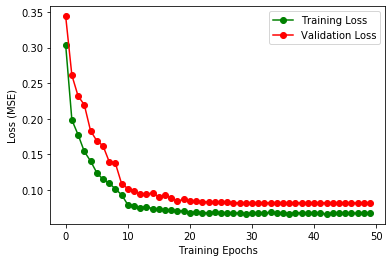

In [280]:
plt.plot(loss_to_plot,'go-', label='Training Loss')
plt.plot(eval_loss_to_plot, 'ro-', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Training Epochs')
plt.ylabel('Loss (MSE)')
plt.show()